In [1]:
import streamlit as st
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Set Options for display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format

from datetime import date
from datetime import datetime
today = date.today()

In [2]:
from data_processing_employees import *
from model_explainer_employees import *
from model_performance_employees import *

loaded_model = pickle.load(open('model_2023_02_27.sav', 'rb'))
explainer = pickle.load(open('explainer_2023_02_27.sav', 'rb'))
feature_importance = pickle.load(open('feature_importance_2023_02_27.sav', 'rb'))

In [3]:
df_employees = pd.read_excel('Integra Employee Sample Data.xlsx')
df_active = df_employees[df_employees['Exit Date'].isnull()].copy()
df_active_original = df_active.copy()

In [4]:
df_active_processed = data_processing_sprout_employees(df_active)
df_active_predict = df_active_processed.drop(["Status"], axis=1)

### Date Range

In [5]:
num_of_months = int(input('Number of Months: '))
additional_days = num_of_months*30
df_active_predict['Tenureship'] = df_active_predict['Tenureship']+additional_days

Number of Months: 0


In [6]:
# predict: status
predicted_status = loaded_model.predict(df_active_predict)
df_active_original['Predicted Status'] = predicted_status
le_status = {0: 'active', 1: 'will churn'}
df_active_original['Predicted Status'] = df_active_original['Predicted Status'].map(le_status)

# predict: distribution score
predicted_probability_status = loaded_model.predict_proba(df_active_predict)
df_active_original[['Will Stay Active','Will Churn']] = predicted_probability_status

# tag: explanation for factors
shap_values = explainer(df_active_predict)
dt_explainer = pd.DataFrame(shap_values.values, columns=df_active_predict.columns)
df_dt_init_explainer = model_explanation_initialization(dt_explainer, explainer)
df_dt_final_explainer = model_explainer_transpose(df_dt_init_explainer)

In [7]:
df_active_original.reset_index(drop=True,inplace=True)
df_dt_final_explainer.reset_index(drop=True,inplace=True)
df_final_result = pd.concat([df_active_original,df_dt_final_explainer],axis=1)

### Feature Engineering for Display

In [8]:
# feature engineering: tenureship
df_final_result['Tenureship'] = df_final_result.apply(lambda x: (datetime.now() - x['Hire Date']).days  if pd.isnull(x['Exit Date']) else (x['Exit Date'] - x['Hire Date']).days, axis=1)
df_final_result['Tenureship'].fillna(0, inplace=True)
df_final_result['Tenureship'] = df_final_result['Tenureship']+additional_days

# feature engineering: tenure range
df_final_result['Tenureship_Range'] = df_final_result['Tenureship'].apply(lambda x: '< 1 year' if x<365 
                                                    else '1-3 years' if x>=365 and x<1095
                                                    else '3-5 years' if x>=1095 and x<1825
                                                    else '5-10 years' if x>=1825 and x<3650
                                                    else '10 years')

# feature engineering: age banding
df_final_result['Age Banding'] = df_final_result['Age'].apply(lambda x: 'Gen Z' if x<=22 
                                                    else 'Zillenial' if x>22 and x<=26
                                                    else 'Millenial' if x>26 and x<=42
                                                    else 'Gen X' if x>42 and x<=58
                                                    else 'Boomers' if x>58 and x<=68
                                                    else 'Others')

### Employee Prediction Per Row

In [9]:
df_final_result

,EEID,Full Name,Job Title,Department,Employee Group,Gender,Marital Status,Education,Age,Hire Date,Annual Salary,Daily Rate,Hourly Rate,Bonus %,Salary Hike %,Country,City,Distance Fom Home (km),Travel,Satisfaction,Separation Type,Exit Date,Predicted Status,Will Stay Active,Will Churn,Factor_1,Score_1,Factor_2,Score_2,Factor_3,Score_3,Factor_4,Score_4,Factor_5,Score_5,Factor_6,Score_6,Factor_7,Score_7,Factor_8,Score_8,Factor_9,Score_9,Factor_10,Score_10,Factor_11,Score_11,Factor_12,Score_12,Factor_13,Score_13,Factor_14,Score_14,Tenureship,Tenureship_Range,Age Banding
0,E02706,Nevaeh Kang,Sales Associate II,Business Development,Corporate,Female,Married,Graduate,25,2021-01-10,572000,2200.00,275.00,0.09,0.05,Philippines,Cebu,1,Non_Travel,5,NaN,NaT,active,0.60,0.40,Age,0.35,Tenureship,0.21,Satisfaction,0.10,Job Title,0.08,Salary Hike %,0.03,Distance Fom Home (km),0.02,Education,0.02,City,0.01,Bonus %,0.01,Annual Salary Grade,0.01,Department,0.00,Employee Group,0.00,Travel,0.00,Gender,0.00,778,1-3 years,Zillenial
1,E04222,Quinn Xiong,Manager,Finance,Corporate,Female,Single,Graduate,38,2019-09-08,1430000,5500.00,687.50,0.08,0.05,Philippines,Manila,3,Travel_Rarely,4,NaN,NaT,will churn,0.20,0.80,Age,0.35,Tenureship,0.17,Satisfaction,0.10,Salary Hike %,0.07,Job Title,0.07,Bonus %,0.04,Education,0.02,City,0.01,Annual Salary Grade,0.01,Employee Group,0.00,Department,0.00,Travel,0.00,Gender,0.00,Distance Fom Home (km),0.00,1268,3-5 years,Millenial
2,E03278,Nicholas Wong,Supervisor,Operations,Call Center,Male,Single,Undergraduate,38,2019-11-07,669500,2575.00,321.88,0.08,0.05,Philippines,Davao,21,Non_Travel,4,NaN,NaT,active,0.80,0.20,Age,0.35,Tenureship,0.17,Satisfaction,0.10,Salary Hike %,0.07,Job Title,0.07,Bonus %,0.04,Education,0.02,City,0.01,Annual Salary Grade,0.01,Employee Group,0.00,Department,0.00,Travel,0.00,Gender,0.00,Distance Fom Home (km),0.00,1208,3-5 years,Millenial
3,E02649,Charles Gonzalez,Supervisor,Operations,Shared Services,Male,Single,Post-Graduate,38,2018-09-28,624000,2400.00,300.00,0.07,0.03,Philippines,Davao,19,Non_Travel,3,NaN,NaT,will churn,0.20,0.80,Age,0.35,Tenureship,0.21,Satisfaction,0.10,Job Title,0.08,Salary Hike %,0.03,Distance Fom Home (km),0.02,Education,0.02,City,0.01,Bonus %,0.01,Annual Salary Grade,0.01,Department,0.00,Employee Group,0.00,Travel,0.00,Gender,0.00,1613,3-5 years,Millenial
4,E03720,Genesis Hunter,Manager,Finance,Corporate,Female,Single,Graduate,38,2021-04-22,1716000,6600.00,825.00,0.05,0.04,Philippines,Manila,6,Travel_Rarely,4,NaN,NaT,will churn,0.20,0.80,Age,0.35,Tenureship,0.21,Satisfaction,0.10,Job Title,0.08,Salary Hike %,0.03,Distance Fom Home (km),0.02,Education,0.02,City,0.01,Bonus %,0.01,Annual Salary Grade,0.01,Department,0.00,Employee Group,0.00,Travel,0.00,Gender,0.00,676,1-3 years,Millenial
5,E03642,Aria Roberts,Manager,Finance,Corporate,Female,Single,Graduate,38,2015-08-12,1755000,6750.00,843.75,0.05,0.04,Philippines,Manila,7,Travel_Rarely,3,NaN,NaT,active,1.00,0.00,Age,0.35,Tenureship,0.21,Satisfaction,0.10,Job Title,0.08,Salary Hike %,0.03,Distance Fom Home (km),0.02,Education,0.02,City,0.01,Bonus %,0.01,Annual Salary Grade,0.01,Department,0.00,Employee Group,0.00,Travel,0.00,Gender,0.00,2756,5-10 years,Millenial
6,E01578,Anthony Hong,Supervisor,Operations,Call Center,Male,Single,Undergraduate,37,2016-11-29,669500,2575.00,321.88,0.11,0.03,Philippines,Manila,2,Non_Travel,5,NaN,NaT,active,1.00,0.00,Age,0.35,Tenureship,0.21,Satisfaction,0.10,Job Title,0.08,Salary Hike %,0.03,Distance Fom Home (km),0.02,Education,0.02,City,0.01,Bonus %,0.01,Annual Salary Grade,0.01,Department,0.00,Employee Group,0.00,Travel,0.00,Gender,0.00,2281,5-10 years,Millenial
7,E03096,Kennedy Zhang,Manager,Finance,Corporate,Female,Single,Graduate,37,2022-10-27,1430000,5500.00,687.50,0.09,0.03,Philippines,Manila,25,Travel_Rarely,3,NaN,NaT,will churn,0.00,1.00,Age,0.35,Tenureship,0.19,Satisfaction,0.11,Job Title,0.06,Salary Hike %,0.04,Distance Fom Home (km),0.02,Education,0.02,Bonus %,0.01,City,0.01,Annual 

### Attrition Breakout

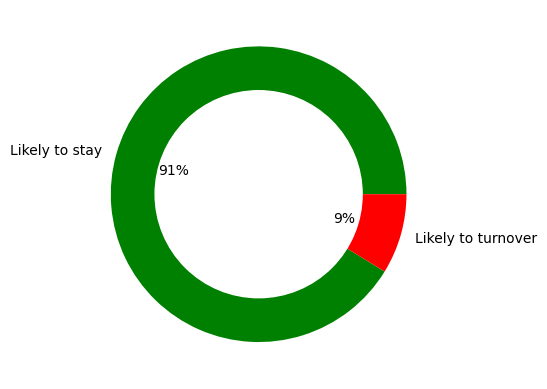

In [10]:
total = df_final_result.shape[0]
likely_to_stay = round(len(df_final_result[df_final_result['Predicted Status']=='active'])/total*100,2)
likely_to_turnover = round(len(df_final_result[df_final_result['Predicted Status']!='active'])/total*100,2)

data=[likely_to_stay,likely_to_turnover]
label=['Likely to stay', 'Likely to turnover']
plt.pie(data, labels=label, colors=['green','red'], autopct='%.0f%%')
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### ! If no action is taken

In [11]:
total_churn = df_final_result[df_final_result['Predicted Status']!='active'].shape[0]
major_BU_label = df_final_result[df_final_result['Predicted Status']!='active']['Department'].value_counts()[:1].index[0]
major_BU_percent = round(df_final_result[df_final_result['Predicted Status']!='active']['Department'].value_counts()[:1][0]/total_churn*100,2)

print("{}% will be coming from {}.".format(major_BU_percent,major_BU_label))
print("Attrition will be driven by {}.".format(feature_importance['Factors'][0]))

63.16% will be coming from Operations.
Attrition will be driven by Tenureship.


### By Business Unit

<AxesSubplot:>

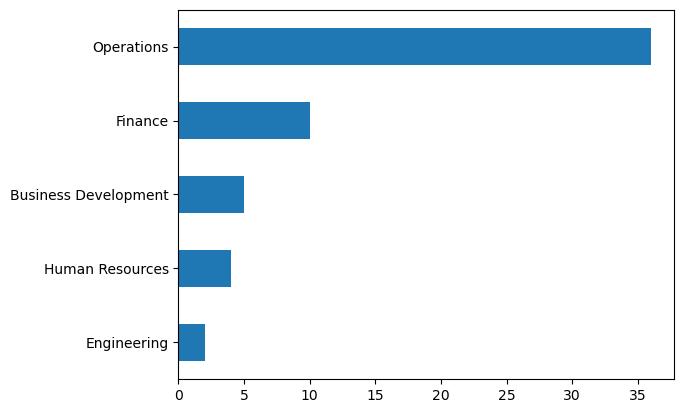

In [12]:
df_final_result[df_final_result['Predicted Status']!='active']['Department'].value_counts().sort_values().plot(kind='barh')

### By Tenure Range

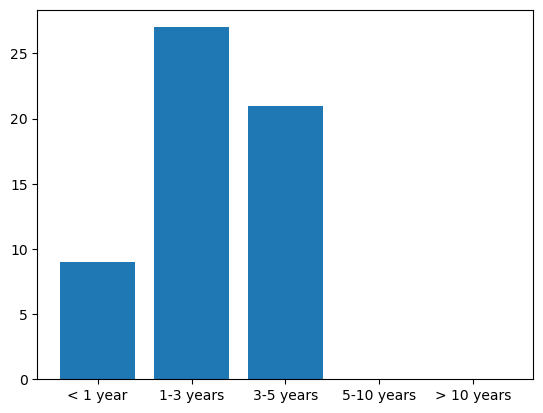

In [13]:
less_than_a_year_count = df_final_result[(df_final_result['Predicted Status']!='active') & (df_final_result['Tenureship_Range']=='< 1 year')].shape[0]
one_year_to_three_years_count = df_final_result[(df_final_result['Predicted Status']!='active') & (df_final_result['Tenureship_Range']=='1-3 years')].shape[0]
three_to_five_years_count = df_final_result[(df_final_result['Predicted Status']!='active') & (df_final_result['Tenureship_Range']=='3-5 years')].shape[0]
five_to_ten_years_count = df_final_result[(df_final_result['Predicted Status']!='active') & (df_final_result['Tenureship_Range']=='5-10 years')].shape[0]
ten_years_over_count = df_final_result[(df_final_result['Predicted Status']!='active') & (df_final_result['Tenureship_Range']=='10 years')].shape[0]

y=[less_than_a_year_count,one_year_to_three_years_count,three_to_five_years_count,five_to_ten_years_count,ten_years_over_count]
x=['< 1 year','1-3 years','3-5 years','5-10 years','> 10 years']
plt.bar(x,y) 
plt.show()

### By Age Banding

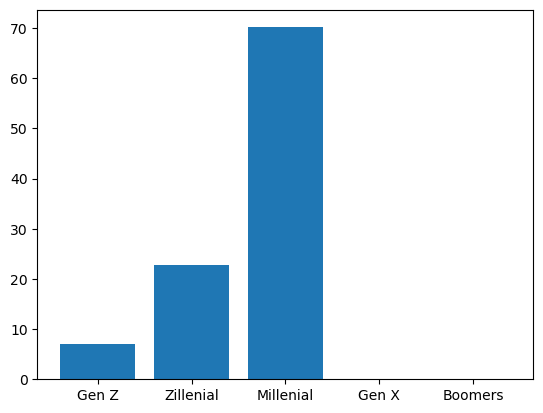

In [14]:
gen_z_count = df_final_result[(df_final_result['Predicted Status']!='active') & (df_final_result['Age Banding']=='Gen Z')].shape[0]
zillenial_count = df_final_result[(df_final_result['Predicted Status']!='active') & (df_final_result['Age Banding']=='Zillenial')].shape[0]
millenial_count = df_final_result[(df_final_result['Predicted Status']!='active') & (df_final_result['Age Banding']=='Millenial')].shape[0]
gen_x_count = df_final_result[(df_final_result['Predicted Status']!='active') & (df_final_result['Age Banding']=='Gen X')].shape[0]
boomers_count = df_final_result[(df_final_result['Predicted Status']!='active') & (df_final_result['Age Banding']=='Boomers')].shape[0]

total_active = df_final_result[df_final_result['Predicted Status']!='active'].shape[0]
gen_z_percentage = round(gen_z_count/total_active*100,2)
zillenial_percentage = round(zillenial_count/total_active*100,2)
millenial_percentage = round(millenial_count/total_active*100,2)
gen_x_percentage = round(gen_x_count/total_active*100,2)
boomers_percentage = round(boomers_count/total_active*100,2)

b=[gen_z_percentage,zillenial_percentage,millenial_percentage,gen_x_percentage,boomers_percentage]
a=['Gen Z','Zillenial','Millenial','Gen X','Boomers']
plt.bar(a,b) 
plt.show()

### Job Role Waterfall

<AxesSubplot:>

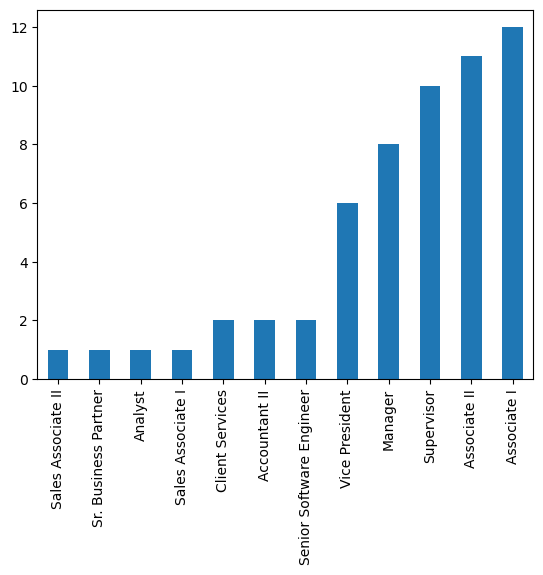

In [15]:
df_final_result[df_final_result['Predicted Status']!='active']['Job Title'].value_counts().sort_values().plot(kind='bar')

### By Gender

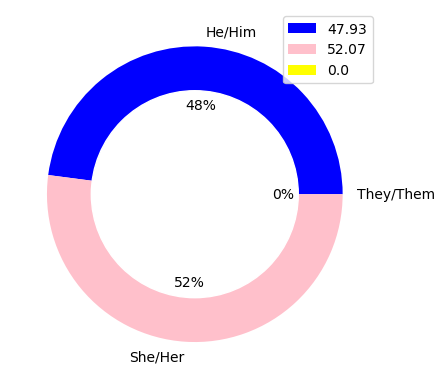

In [16]:
total = df_final_result.shape[0]
male_count = round(len(df_final_result[df_final_result['Gender']=='Male'])/total*100,2)
female_count = round(len(df_final_result[df_final_result['Gender']=='Female'])/total*100,2)
lqbtqia_count = round(len(df_final_result[(df_final_result['Gender']!='Male') &
                                         (df_final_result['Gender']!='Female')])/total*100,2)

data_gender=[male_count,female_count, lqbtqia_count]
label_gender=['He/Him', 'She/Her', 'They/Them']
plt.pie(data_gender, labels=label_gender, colors=['blue','pink', 'yellow'], autopct='%.0f%%')
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.legend(data_gender, loc="best")
plt.show()

### Drivers for Attrition

In [17]:
feature_importance['Importance'] = feature_importance['Importance'].apply(lambda x: x*100)
feature_importance[:5]

,Factors,Importance
0,Tenureship,53.45
1,Age,19.88
2,Job Title,12.06
3,Satisfaction,4.46
4,Distance Fom Home (km),3.88
